# FASE PERSIAPAN: SETUP DAN PEMUATAN DATA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [5]:
# Konfigurasi tampilan
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
# Menggunakan plot inline
%matplotlib inline

In [6]:
# --- 1. Memuat Data ---
# Memuat file 'Online_Retail_Clean.csv'
try:
    df_clean = pd.read_csv('../Dataset/Clean/Online_Retail_Clean.csv')
    print("Data berhasil dimuat.")
    print(f"Jumlah baris awal: {len(df_clean)}")
except FileNotFoundError:
    print("Error: File 'Online_Retail_Clean.csv' tidak ditemukan.")
    # Exit atau tambahkan dummy data jika diperlukan untuk testing
    exit()

Data berhasil dimuat.
Jumlah baris awal: 322735


# FASE FEATURE ENGINEERING & MODELLING (SPRINT 2)

In [7]:
## 2.1. Penciptaan Fitur Non-RFM Kunci per Pelanggan

print("Mulai Feature Engineering Non-RFM...")

# Membuat fitur tambahan di level transaksi (ItemsPerInvoice)
item_features = df_clean.groupby('InvoiceNo')['StockCode'].nunique().reset_index()
item_features.rename(columns={'StockCode': 'ItemsPerInvoice'}, inplace=True)
df_clean = pd.merge(df_clean, item_features, on='InvoiceNo', how='left')


# Aggregasi data ke level CustomerID
customer_features = df_clean.groupby('CustomerID').agg(
    # Fitur 1: Total Quantity Dibeli
    TotalQuantityDibeli=('Quantity', 'sum'),

    # Fitur 2: Total Pengeluaran (Pengganti Moneter)
    TotalPengeluaran=('TotalPrice', 'sum'),

    # Fitur 3: Jumlah Transaksi (Pengganti Frekuensi)
    JumlahTransaksi=('InvoiceNo', 'nunique'),

    # Fitur 4: Rata-rata Nilai Transaksi (Avg Order Value)
    RataRataNilaiTransaksi=('TotalPrice', 'mean'),

    # Fitur 5: Jumlah Kategori/Item Unik yang Dibeli
    JumlahItemUnik=('StockCode', 'nunique'),

    # Fitur 6: Rata-rata Items per Invoice (Variasi Belanja per Transaksi)
    RataRataItemPerInvoice=('ItemsPerInvoice', 'mean'),
).reset_index()

# Fitur Tambahan: Rata-rata Pengeluaran per Item
customer_features['AvgPengeluaranPerItem'] = customer_features['TotalPengeluaran'] / customer_features['JumlahItemUnik']

# Pilih fitur yang akan digunakan untuk clustering
features_to_cluster = [
    'TotalQuantityDibeli',
    'TotalPengeluaran',
    'JumlahTransaksi',
    'RataRataNilaiTransaksi',
    'JumlahItemUnik',
    'RataRataItemPerInvoice',
    'AvgPengeluaranPerItem'
]

X = customer_features[features_to_cluster].copy()

# Penanganan Nilai Abnormal (Infiniti atau NaN yang mungkin muncul dari pembagian)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

print(f"Jumlah baris setelah feature engineering dan penanganan NaN: {len(X)}")

Mulai Feature Engineering Non-RFM...
Jumlah baris setelah feature engineering dan penanganan NaN: 4178


In [8]:
## 2.2. Scaling Data: Normalisasi menggunakan StandardScaler

print("Mulai Scaling Data menggunakan StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=features_to_cluster)

# Tampilkan 5 baris pertama dari data yang sudah di-scale
print("\n--- Hasil Kerja Sprint 2: Data Scaled (Head) ---")
print(df_scaled.head())

Mulai Scaling Data menggunakan StandardScaler...

--- Hasil Kerja Sprint 2: Data Scaled (Head) ---
   TotalQuantityDibeli  TotalPengeluaran  JumlahTransaksi  \
0             1.048831          1.161454         0.434812   
1            -0.366814         -0.431563        -0.141443   
2            -0.065959         -0.013293        -0.429571   
3            -0.321279         -0.328398        -0.429571   
4            -0.093605          0.021183         0.434812   

   RataRataNilaiTransaksi  JumlahItemUnik  RataRataItemPerInvoice  \
0                0.342842        0.574207                0.233794   
1               -0.103391       -0.643286               -0.932604   
2                0.111990       -0.000341                1.497392   
3                0.213349       -0.506489               -0.300805   
4                0.055069       -0.109778               -0.599818   

   AvgPengeluaranPerItem  
0               0.770823  
1              -0.271385  
2              -0.146513  
3          

In [9]:
## 2.3. Implementasi Clustering Awal (K-Means - Penyiapan)
# Implementasi K-Means yang sebenarnya (pemilihan K) akan dilakukan di Sprint 3,
# tetapi persiapan data scaled ini adalah hasil utama Sprint 2.
print("\nModel K-Means Awal siap untuk dievaluasi di Sprint 3.")


Model K-Means Awal siap untuk dievaluasi di Sprint 3.


# FASE EVALUASI & PROFILING (SPRINT 3)

In [10]:
## 3.1. Evaluasi Model: Penentuan K Optimal
print("Mulai Evaluasi Model (Menentukan K Optimal)...")

# Inisialisasi list untuk Elbow Method dan Silhouette Score
inertia = []
silhouette_scores = []
K_range = range(2, 11) # Coba K dari 2 sampai 10

best_k = None
best_score = -1  # nilai awal untuk pembanding

for k in K_range:
    # Membangun dan melatih model K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    # Kriteria: Inertia (Elbow Method)
    inertia.append(kmeans.inertia_)

    # Kriteria: Silhouette Score
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

    # Cari nilai K terbaik berdasarkan silhouette score tertinggi
    if score > best_score:
        best_score = score
        best_k = k

Mulai Evaluasi Model (Menentukan K Optimal)...


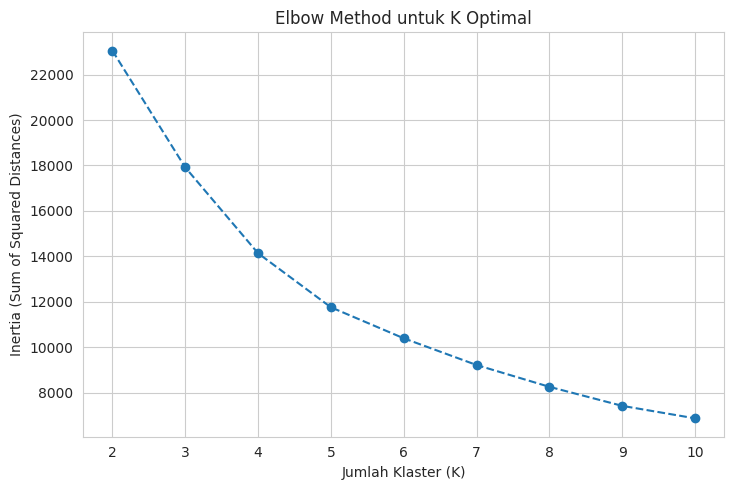

In [11]:
# Visualisasi Elbow Method
plt.figure(figsize=(14, 5))

# Plot Elbow Method
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method untuk K Optimal')
plt.xlabel('Jumlah Klaster (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(K_range)

plt.tight_layout()
plt.show()

In [12]:
# Menampilkan hasil Silhoutte Score
print(f"Nilai Silhouette Score tertinggi: {best_score:.4f}")

Nilai Silhouette Score tertinggi: 0.5658


In [13]:
# Menentukan K optimal (misalnya K=4, berdasarkan visualisasi yang umum)
optimal_k = 4
print(f"Keputusan: Berdasarkan evaluasi visual, K optimal dipilih = {optimal_k}")

Keputusan: Berdasarkan evaluasi visual, K optimal dipilih = 4


In [14]:
## 3.2. Implementasi Klaster Akhir
print(f"\nMelatih Model K-Means Akhir dengan K = {optimal_k}...")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_scaled)

# Tambahkan kolom klaster ke df_scaled
df_scaled['Cluster'] = kmeans_final.labels_

# Gabungkan klaster ke customer_features berdasarkan index
customer_features['Cluster'] = df_scaled['Cluster'].values


Melatih Model K-Means Akhir dengan K = 4...



Membuat visualisasi hasil clustering...


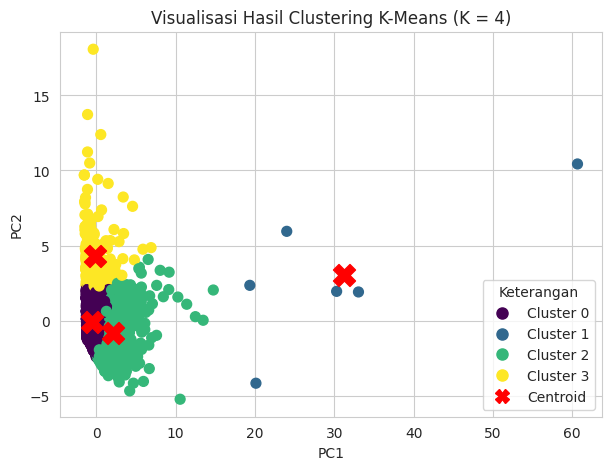

In [16]:
# Visualisasi hasil clustering dalam ruang dua dimensi hasil proyeksi PCA

print("\nMembuat visualisasi hasil clustering...")

# Mengubah data fitur bernormalisasi ke bentuk 2 dimensi untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Mendapatkan label klaster model final
labels = kmeans_final.labels_
n_clusters = kmeans_final.n_clusters

plt.figure(figsize=(7, 5))

# Scatter untuk seluruh data
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)

# Hitung centroid dalam ruang PCA
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
centroid_scatter = plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c='red', s=250, marker='X', label='Centroid'
)

# -------- Membuat legend per cluster --------
handles = []
labels_legend = []

# Ambil warna unik dari scatter berdasarkan klaster
colors = scatter.cmap(scatter.norm(np.arange(n_clusters)))

for i in range(n_clusters):
    handles.append(plt.Line2D([0], [0], marker='o', color=colors[i], linestyle='', markersize=8))
    labels_legend.append(f'Cluster {i}')

# Tambahkan centroid ke legend
handles.append(plt.Line2D([0], [0], marker='X', color='red', linestyle='', markersize=10))
labels_legend.append('Centroid')

plt.legend(handles, labels_legend, title="Keterangan")

plt.title(f'Visualisasi Hasil Clustering K-Means (K = {optimal_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [17]:
## 3.3. Analisis Klaster: Membuat Profil Segmen Pelanggan

print("Mulai Analisis Karakteristik Statistik Setiap Klaster...")

# Hitung statistik rata-rata (mean) dari fitur Non-RFM per klaster
cluster_profile = customer_features.groupby('Cluster')[features_to_cluster].mean().reset_index()

print("\n--- Ringkasan Profil Klaster (Rata-rata Fitur Non-RFM) ---")
print(cluster_profile.round(2))

Mulai Analisis Karakteristik Statistik Setiap Klaster...

--- Ringkasan Profil Klaster (Rata-rata Fitur Non-RFM) ---
   Cluster  TotalQuantityDibeli  TotalPengeluaran  JumlahTransaksi  \
0        0               320.08            503.54             2.59   
1        1             21987.83          35096.35           107.50   
2        2              1645.76           2549.29             8.64   
3        3               546.49           1304.24             6.82   

   RataRataNilaiTransaksi  JumlahItemUnik  RataRataItemPerInvoice  \
0                   15.31           30.66                   17.00   
1                   13.61         1003.17                   93.38   
2                   11.26          155.12                   49.33   
3                   48.08           18.38                    5.88   

   AvgPengeluaranPerItem  
0                  17.21  
1                  38.59  
2                  17.09  
3                  77.33  


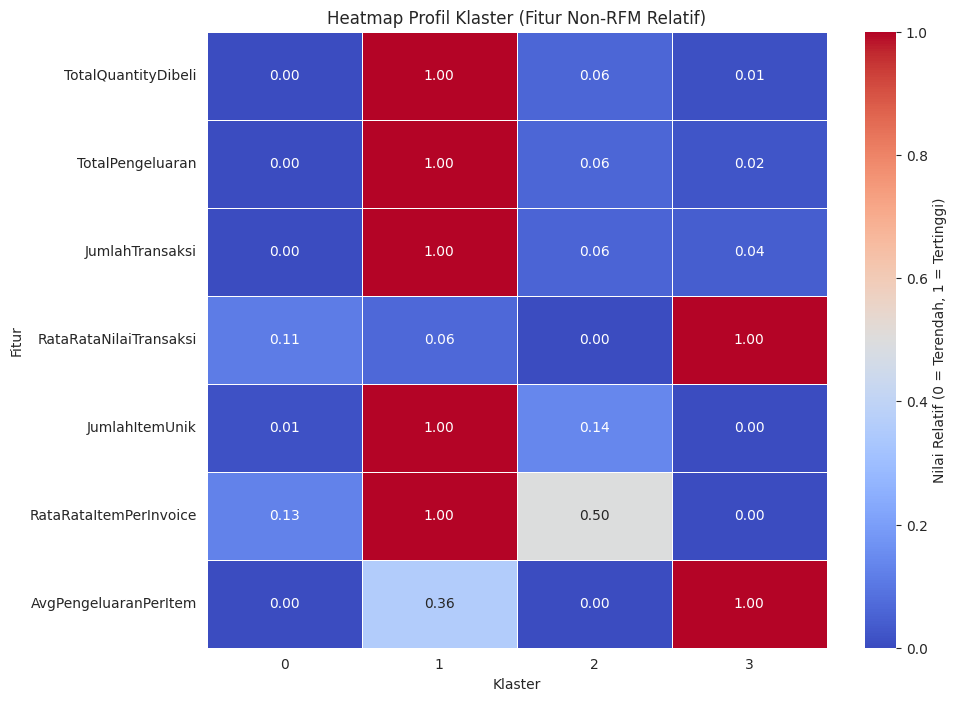

In [18]:
## 3.4. Visualisasi Profil Klaster (untuk Wawasan Bisnis)

# Scaling data profil klaster untuk visualisasi perbandingan (min-max scaling sederhana)
cluster_profile_scaled = cluster_profile.set_index('Cluster').copy()
cluster_profile_scaled = cluster_profile_scaled.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# Visualisasi Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_profile_scaled.T, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, cbar_kws={'label': 'Nilai Relatif (0 = Terendah, 1 = Tertinggi)'})
plt.title('Heatmap Profil Klaster (Fitur Non-RFM Relatif)')
plt.ylabel('Fitur')
plt.xlabel('Klaster')
plt.show()